## Data Preperation

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)
pd.reset_option('max_rows')


/tmp/ipykernel_16256/5912901.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Columns relevant to the time-series analysis
columns_to_load = [
    'date', 'subregion2_name', 'subregion1_name',
    'new_confirmed', 'new_deceased',
    'cumulative_confirmed', 'cumulative_deceased',
    'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated',
    'population',
    'average_temperature_celsius', 'minimum_temperature_celsius',
    'maximum_temperature_celsius', 'rainfall_mm', 'relative_humidity'
]

# Directory path to CSV files
# directory_path = "../Test CSVs/"  
directory_path = "../All CSVs/"  

# Initialize an empty DataFrame to store data from all CSV files
full_df = pd.DataFrame()

# Efficiently load CSV files
for file in glob.glob(directory_path + '*.csv'):
    df = pd.read_csv(file, usecols=lambda column: column in columns_to_load)
    full_df = pd.concat([full_df, df], ignore_index=True)

full_df.reset_index(drop=True, inplace=True)


In [3]:
# Convert 'date' to datetime and setup time-based grouping
full_df['date'] = pd.to_datetime(full_df['date'])
full_df['week'] = full_df['date'] - pd.to_timedelta(full_df['date'].dt.weekday, unit='d')
full_df['county_name'] = full_df['subregion2_name'] + ', ' + full_df['subregion1_name']

# Define columns to keep for analysis
columns_to_keep = [
    'county_name', 'week', 'date', 'new_confirmed', 'new_deceased',
    'cumulative_confirmed', 'cumulative_deceased',
    'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated',
    'population', 'average_temperature_celsius', 'minimum_temperature_celsius',
    'maximum_temperature_celsius', 'rainfall_mm', 'relative_humidity'
]

full_df = full_df[columns_to_keep]

# Group by 'county_name' and 'week', aggregate relevant metrics
aggregations = {
    'new_confirmed': 'sum', 'new_deceased': 'sum',
    'cumulative_confirmed': 'max', 'cumulative_deceased': 'max',
    'new_persons_fully_vaccinated': 'sum', 'cumulative_persons_fully_vaccinated': 'max',
    'population': 'mean', 'average_temperature_celsius': 'mean',
    'minimum_temperature_celsius': 'mean', 'maximum_temperature_celsius': 'mean',
    'rainfall_mm': 'sum', 'relative_humidity': 'mean'
}

weekly_df = full_df.groupby(['county_name', 'week']).agg(aggregations).reset_index()
weekly_df['description'] = weekly_df['county_name'] + " - Week of " + weekly_df['week'].dt.strftime('%Y-%m-%d')



In [4]:
# Normalization by population
normalize_columns = [
    'new_confirmed', 'new_deceased', 'cumulative_confirmed', 'cumulative_deceased',
    'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated'
]

# Normalization by population per 1000
def normalize_by_population_per_1000(df, columns):
    for col in columns:
        df[f'{col}_per_1000'] = df[col] / df['population'] * 1000
    return df

# Apply normalization per 1000
weekly_df = normalize_by_population_per_1000(weekly_df, normalize_columns)


# Normalization by population per 100
def normalize_by_population_per_100(df, columns):
    for col in columns:
        df[f'{col}_per_100'] = df[col] / df['population'] * 100
    return df

# Apply normalization per 100
weekly_df = normalize_by_population_per_100(weekly_df, normalize_columns)


In [5]:
# Display the first 5 rows of the DataFrame
display(weekly_df.head())

# Display the last 5 rows of the DataFrame
display(weekly_df.tail())


,county_name,week,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,population,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,relative_humidity,description,new_confirmed_per_1000,new_deceased_per_1000,cumulative_confirmed_per_1000,cumulative_deceased_per_1000,new_persons_fully_vaccinated_per_1000,cumulative_persons_fully_vaccinated_per_1000,new_confirmed_per_100,new_deceased_per_100,cumulative_confirmed_per_100,cumulative_deceased_per_100,new_persons_fully_vaccinated_per_100,cumulative_persons_fully_vaccinated_per_100
0,"Abbeville County, South Carolina",2019-12-30,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,8.723457,3.902469,14.848148,47.514933,69.717392,"Abbeville County, South Carolina - Week of 201...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
1,"Abbeville County, South Carolina",2020-01-06,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,11.157628,4.387676,17.655974,27.839811,63.814132,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
2,"Abbeville County, South Carolina",2020-01-13,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,11.964853,8.557681,16.021825,47.280286,72.284059,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
3,"Abbeville County, South Carolina",2020-01-20,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,3.712522,-1.368607,9.614638,15.072078,58.716494,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
4,"Abbeville County, South Carolina",2020-01-27,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,6.669863,1.384149,13.074405,5.791200,71.734793,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN


,county_name,week,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,population,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,relative_humidity,description,new_confirmed_per_1000,new_deceased_per_1000,cumulative_confirmed_per_1000,cumulative_deceased_per_1000,new_persons_fully_vaccinated_per_1000,cumulative_persons_fully_vaccinated_per_1000,new_confirmed_per_100,new_deceased_per_100,cumulative_confirmed_per_100,cumulative_deceased_per_100,new_persons_fully_vaccinated_per_100,cumulative_persons_fully_vaccinated_per_100
458087,"Ziebach County, South Dakota",2022-08-15,0.0,0.0,NaN,NaN,3.0,1016.0,2748.0,22.525397,14.040476,31.961111,2.3368,53.994944,"Ziebach County, South Dakota - Week of 2022-08-15",0.0,0.0,NaN,NaN,1.091703,369.723435,0.0,0.0,NaN,NaN,0.109170,36.972344
458088,"Ziebach County, South Dakota",2022-08-22,0.0,0.0,NaN,NaN,0.0,1016.0,2748.0,22.690476,15.157143,32.207936,31.0134,58.884666,"Ziebach County, South Dakota - Week of 2022-08-22",0.0,0.0,NaN,NaN,0.000000,369.723435,0.0,0.0,NaN,NaN,0.000000,36.972344
458089,"Ziebach County, South Dakota",2022-08-29,0.0,0.0,NaN,NaN,0.0,NaN,2748.0,22.766667,12.046825,33.637302,0.0000,40.122969,"Ziebach County, South Dakota - Week of 2022-08-29",0.0,0.0,NaN,NaN,0.000000,NaN,0.0,0.0,NaN,NaN,0.000000,NaN
458090,"Ziebach County, South Dakota",2022-09-05,0.0,0.0,NaN,NaN,13.0,1029.0,2748.0,20.122222,10.872222,30.604762,5.9690,47.010269,"Ziebach County, South Dakota - Week of 2022-09-05",0.0,0.0,NaN,NaN,4.730713,374.454148,0.0,0.0,NaN,NaN,0.473071,37.445415
458091,"Ziebach County, South Dakota",2022-09-12,0.0,0.0,NaN,NaN,0.0,1029.0,2748.0,18.285185,9.370370,28.005555,0.0000,49.467567,"Ziebach County, South Dakota - Week of 2022-09-12",0.0,0.0,NaN,NaN,0.000000,374.454148,0.0,0.0,NaN,NaN,0.000000,37.445415


In [6]:
# Display statistical summaries of the DataFrame
display(weekly_df.describe())


,week,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,population,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,relative_humidity,new_confirmed_per_1000,new_deceased_per_1000,cumulative_confirmed_per_1000,cumulative_deceased_per_1000,new_persons_fully_vaccinated_per_1000,cumulative_persons_fully_vaccinated_per_1000,new_confirmed_per_100,new_deceased_per_100,cumulative_confirmed_per_100,cumulative_deceased_per_100,new_persons_fully_vaccinated_per_100,cumulative_persons_fully_vaccinated_per_100
count,458092,458092.000000,458092.000000,3.587430e+05,348639.000000,4.580920e+05,2.318040e+05,4.580920e+05,457524.000000,457524.000000,457524.000000,458092.000000,457236.000000,458092.000000,458092.000000,358743.000000,348639.000000,458092.000000,231804.000000,458092.000000,458092.000000,358743.000000,348639.000000,458092.000000,231804.000000
mean,2021-05-06 11:59:59.999999232,179.512369,2.147898,1.028986e+04,162.638110,2.894118e+02,5.550123e+04,1.021204e+05,14.172875,8.513542,20.844920,14.291920,66.624954,1.746549,0.025733,101.282992,1.757597,2.170569,442.737992,0.174655,0.002573,10.128299,0.175760,0.217057,44.273799
min,2019-12-30 00:00:00,-8240.000000,-792.000000,0.000000e+00,0.000000,-5.408200e+04,0.000000e+00,8.600000e+01,-38.327602,-42.318254,-34.459609,0.000000,7.660378,-119.744004,-2.808989,0.000000,0.000000,-1389.024988,0.000000,-11.974400,-0.280899,0.000000,0.000000,-138.902499,0.000000
25%,2020-08-31 00:00:00,0.000000,0.000000,3.990000e+02,7.000000,0.000000e+00,3.876750e+03,1.118100e+04,6.665079,0.922354,13.603175,1.778000,59.859638,0.000000,0.000000,21.861103,0.332975,0.000000,352.800203,0.000000,0.000000,2.186110,0.033297,0.000000,35.280020
50%,2021-05-06 12:00:00,14.000000,0.000000,1.832000e+03,34.000000,0.000000e+00,1.063200e+04,2.610250e+04,15.511905,9.180776,22.828472,8.045450,69.272196,0.577201,0.000000,92.137592,1.446132,0.000000,446.795500,0.057720,0.000000,9.213759,0.144613,0.000000,44.679550
75%,2022-01-10 00:00:00,79.000000,1.000000,6.066000e+03,103.000000,4.400000e+01,3.044575e+04,6.682200e+04,22.818342,16.926191,29.306349,20.590933,75.922987,2.125893,0.022665,152.871634,2.740052,1.795715,545.953270,0.212589,0.002267,15.287163,0.274005,0.179572,54.595327
max,2022-09-12 00:00:00,290059.000000,1598.000000,2.908425e+06,32022.000000,2.628479e+06,7.388754e+06,1.010371e+07,38.850617,31.291182,46.281305,283.453416,95.915777,225.563910,7.518797,1473.684211,12.029611,926.587302,4001.861832,22.556391,0.751880,147.368421,1.202961,92.658730,400.186183
std,NaN,1347.267786,13.787415,4.499129e+04,670.086845,6.078696e+03,2.043441e+05,3.278694e+05,10.101307,10.134288,10.289791,17.513041,13.113817,3.265137,0.077805,85.501838,1.602419,13.521037,173.858599,0.326514,0.007781,8.550184,0.160242,1.352104,17.385860


In [7]:
# Display data types and non-null counts
display(weekly_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458092 entries, 0 to 458091
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   county_name                                   458092 non-null  object        
 1   week                                          458092 non-null  datetime64[ns]
 2   new_confirmed                                 458092 non-null  float64       
 3   new_deceased                                  458092 non-null  float64       
 4   cumulative_confirmed                          358743 non-null  float64       
 5   cumulative_deceased                           348639 non-null  float64       
 6   new_persons_fully_vaccinated                  458092 non-null  float64       
 7   cumulative_persons_fully_vaccinated           231804 non-null  float64       
 8   population                                    458092 n

None

In [8]:
# Display the number of unique counties
print("Unique counties:", weekly_df['county_name'].nunique())

# Display unique values in another column of interest
print("Unique weeks sampled:", weekly_df['week'].nunique())


Unique counties: 3226
Unique weeks sampled: 142


In [9]:
# Display a random sample of 5 rows from the DataFrame
display(weekly_df.sample(5))


,county_name,week,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,population,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,relative_humidity,description,new_confirmed_per_1000,new_deceased_per_1000,cumulative_confirmed_per_1000,cumulative_deceased_per_1000,new_persons_fully_vaccinated_per_1000,cumulative_persons_fully_vaccinated_per_1000,new_confirmed_per_100,new_deceased_per_100,cumulative_confirmed_per_100,cumulative_deceased_per_100,new_persons_fully_vaccinated_per_100,cumulative_persons_fully_vaccinated_per_100
49003,"Cabarrus County, North Carolina",2020-03-30,38.0,0.0,67.0,1.0,0.0,NaN,206988.0,14.376984,6.908730,22.358730,1.260929,46.865171,"Cabarrus County, North Carolina - Week of 2020...",0.183586,0.000000,0.323690,0.004831,0.000000,NaN,0.018359,0.000000,0.032369,0.000483,0.000000,NaN
327109,"Phillips County, Colorado",2021-08-02,1.0,0.0,404.0,13.0,592.0,1733.0,4288.0,23.658400,14.054013,34.222222,2.578100,42.600613,"Phillips County, Colorado - Week of 2021-08-02",0.233209,0.000000,94.216418,3.031716,138.059701,404.151119,0.023321,0.000000,9.421642,0.303172,13.805970,40.415112
284240,"Mono County, California",2021-11-15,17.0,1.0,1786.0,5.0,0.0,0.0,14354.0,8.642063,2.470635,16.413492,0.000000,58.742583,"Mono County, California - Week of 2021-11-15",1.184339,0.069667,124.425247,0.348335,0.000000,0.000000,0.118434,0.006967,12.442525,0.034833,0.000000,0.000000
199972,"Jackson County, Michigan",2020-09-07,68.0,2.0,2665.0,64.0,0.0,NaN,158563.0,17.450000,13.673810,22.465873,52.561671,81.360016,"Jackson County, Michigan - Week of 2020-09-07",0.428852,0.012613,16.807200,0.403625,0.000000,NaN,0.042885,0.001261,1.680720,0.040363,0.000000,NaN
93678,"Corozal Municipio, Puerto Rico",2021-11-29,10.0,0.0,2510.0,NaN,220.0,22914.0,37142.0,26.993651,24.043651,30.230952,7.491589,76.829306,"Corozal Municipio, Puerto Rico - Week of 2021-...",0.269237,0.000000,67.578483,NaN,5.923214,616.929621,0.026924,0.000000,6.757848,NaN,0.592321,61.692962


In [10]:
# Check available columns and sample data to confirm normalization
print(weekly_df.columns)
display(weekly_df.head())

Index(['county_name', 'week', 'new_confirmed', 'new_deceased',
       'cumulative_confirmed', 'cumulative_deceased',
       'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated',
       'population', 'average_temperature_celsius',
       'minimum_temperature_celsius', 'maximum_temperature_celsius',
       'rainfall_mm', 'relative_humidity', 'description',
       'new_confirmed_per_1000', 'new_deceased_per_1000',
       'cumulative_confirmed_per_1000', 'cumulative_deceased_per_1000',
       'new_persons_fully_vaccinated_per_1000',
       'cumulative_persons_fully_vaccinated_per_1000', 'new_confirmed_per_100',
       'new_deceased_per_100', 'cumulative_confirmed_per_100',
       'cumulative_deceased_per_100', 'new_persons_fully_vaccinated_per_100',
       'cumulative_persons_fully_vaccinated_per_100'],
      dtype='object')


,county_name,week,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,population,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,relative_humidity,description,new_confirmed_per_1000,new_deceased_per_1000,cumulative_confirmed_per_1000,cumulative_deceased_per_1000,new_persons_fully_vaccinated_per_1000,cumulative_persons_fully_vaccinated_per_1000,new_confirmed_per_100,new_deceased_per_100,cumulative_confirmed_per_100,cumulative_deceased_per_100,new_persons_fully_vaccinated_per_100,cumulative_persons_fully_vaccinated_per_100
0,"Abbeville County, South Carolina",2019-12-30,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,8.723457,3.902469,14.848148,47.514933,69.717392,"Abbeville County, South Carolina - Week of 201...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
1,"Abbeville County, South Carolina",2020-01-06,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,11.157628,4.387676,17.655974,27.839811,63.814132,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
2,"Abbeville County, South Carolina",2020-01-13,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,11.964853,8.557681,16.021825,47.280286,72.284059,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
3,"Abbeville County, South Carolina",2020-01-20,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,3.712522,-1.368607,9.614638,15.072078,58.716494,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
4,"Abbeville County, South Carolina",2020-01-27,0.0,0.0,NaN,NaN,0.0,NaN,24567.0,6.669863,1.384149,13.074405,5.791200,71.734793,"Abbeville County, South Carolina - Week of 202...",0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN


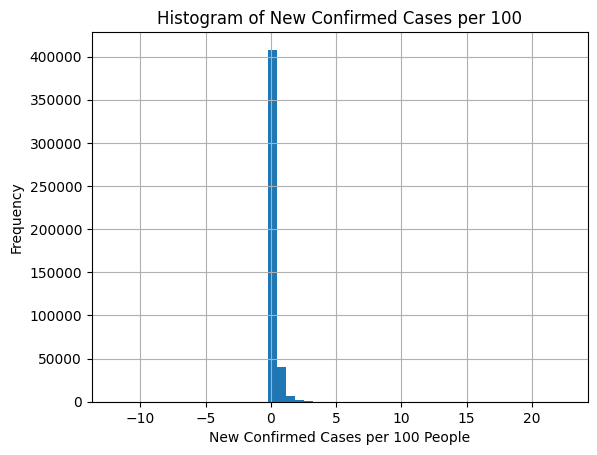

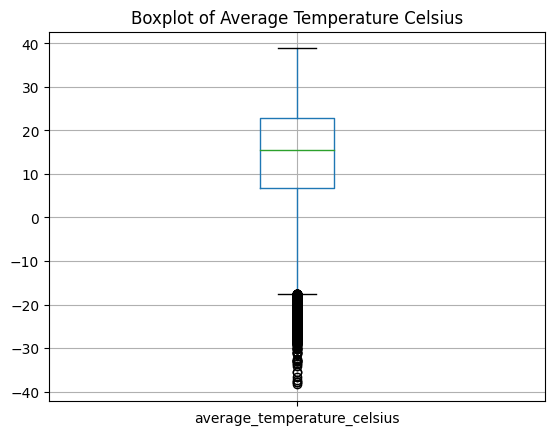

In [11]:
# Histogram of new confirmed cases per 100
weekly_df['new_confirmed_per_100'].hist(bins=50)
plt.title('Histogram of New Confirmed Cases per 100')
plt.xlabel('New Confirmed Cases per 100 People')
plt.ylabel('Frequency')
plt.show()

# Boxplot for average temperature
weekly_df.boxplot(column='average_temperature_celsius')
plt.title('Boxplot of Average Temperature Celsius')
plt.show()


## Statistical Analysis

In [12]:
# Calculate Pearson correlation coefficients
correlation_matrix = weekly_df[[
    'average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius',
    'rainfall_mm', 'relative_humidity',
    'new_confirmed_per_1000', 'new_deceased_per_1000',
    'cumulative_confirmed_per_1000', 'cumulative_deceased_per_1000'
]].corr()

# Display the correlation matrix
display(correlation_matrix)


,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,relative_humidity,new_confirmed_per_1000,new_deceased_per_1000,cumulative_confirmed_per_1000,cumulative_deceased_per_1000
average_temperature_celsius,1.000000,0.984532,0.983666,0.147356,-0.018991,-0.266432,-0.137693,-0.281525,-0.137062
minimum_temperature_celsius,0.984532,1.000000,0.940287,0.203398,0.124071,-0.257916,-0.134347,-0.290621,-0.145751
maximum_temperature_celsius,0.983666,0.940287,1.000000,0.100017,-0.148266,-0.258815,-0.132249,-0.255374,-0.113554
rainfall_mm,0.147356,0.203398,0.100017,1.000000,0.387411,-0.066219,-0.026622,-0.041550,-0.011841
relative_humidity,-0.018991,0.124071,-0.148266,0.387411,1.000000,0.029557,0.012640,-0.078983,-0.053566
new_confirmed_per_1000,-0.266432,-0.257916,-0.258815,-0.066219,0.029557,1.000000,0.210968,0.249713,0.135093
new_deceased_per_1000,-0.137693,-0.134347,-0.132249,-0.026622,0.012640,0.210968,1.000000,0.083576,0.141769
cumulative_confirmed_per_1000,-0.281525,-0.290621,-0.255374,-0.041550,-0.078983,0.249713,0.083576,1.000000,0.774566
cumulative_deceased_per_1000,-0.137062,-0.145751,-0.113554,-0.011841,-0.053566,0.135093,0.141769,0.774566,1.000000


In [13]:
import statsmodels.api as sm

# Prepare the independent variables with a constant added (for the intercept)
X = weekly_df[[
    'average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius',
    'rainfall_mm', 'relative_humidity'
]]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Example dependent variable: new_confirmed_per_1000
y = weekly_df['new_confirmed_per_1000']

# Fit the regression model
model = sm.OLS(y, X, missing='drop')  # 'drop' automatically excludes NaNs
results = model.fit()

# Display the regression results
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     new_confirmed_per_1000   R-squared:                       0.082
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     8209.
Date:                    Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                            12:37:08   Log-Likelihood:            -1.1703e+06
No. Observations:                  457236   AIC:                         2.341e+06
Df Residuals:                      457230   BIC:                         2.341e+06
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

# Overview of Key Components

## Dependent Variable: new_confirmed_per_1000
This variable represents what the model is trying to predict: the number of new confirmed COVID-19 cases per 1000 people.

## Model Fit Statistics
- **R-squared:** 0.082. This value indicates that about 8.2% of the variability in new confirmed cases per 1000 people can be explained by the model's inputs (weather conditions). This indicates a modest level of explanatory power, typical in the context of complex phenomena like disease spread where many factors may influence outcomes.
- **Adj. R-squared:** Also 0.082, suggesting the model is appropriately fitted without redundant predictors.
- **F-statistic and Prob (F-statistic):** The F-statistic is 8209, and the probability is virtually 0. This highlights that the model is statistically significant, indicating a strong relationship between the predictors and the response variable.

## Coefficients
- **const:** The intercept is 2.290. This suggests that, all else being equal, the starting value is approximately 2.290 new confirmed cases per 1000 people.
- **average_temperature_celsius:** A one-degree increase in average temperature is associated with a decrease of 0.845 in new confirmed cases per 1000 people, significant at p < 0.000.
- **minimum_temperature_celsius:** Each degree increase in minimum temperature correlates with an increase of 0.3907 in new cases per 1000, statistically significant.
- **maximum_temperature_celsius:** Each degree increase in maximum temperature is associated with an increase of 0.3750 in new cases per 1000, also significant.
- **rainfall_mm:** Each millimeter of increase in rainfall correlates with a decrease of 0.0105 in new cases per 1000, significant at p < 0.000.
- **relative_humidity:** Each percentage point increase in humidity is associated with an increase of 0.0066 in new cases per 1000, significant at p < 0.000.

## Model Diagnostics
- **Durbin-Watson:** The statistic is 0.579, indicating a strong positive autocorrelation in the residuals of the regression, which could imply missing important time-related or other correlated factors.
- **Omnibus/Prob(Omnibus) and Jarque-Bera (JB)/Prob(JB):** These tests indicate that the residuals are not normally distributed. The very high values (Omnibus, JB) suggest significant issues with the normality assumption, which impacts the reliability of the regression coefficients' standard errors.
- **Skew and Kurtosis:** High values indicate a highly skewed and leptokurtic distribution of residuals, pointing to substantial outliers or non-uniformity in the data distribution.

## Interpretation
The results underline that weather conditions have a statistically significant, yet modest impact on the spread of COVID-19, as reflected in the R-squared value. The significant autocorrelation detected by the Durbin-Watson statistic and the non-normal distribution of residuals suggest that further model refinement is necessary, potentially including time-series specific models that can handle autocorrelation and non-linear dependencies more effectively.

These diagnostics indicate potential issues with model assumptions and suggest that exploring more complex models or adding additional predictors could provide more accurate insights. Consideration of non-linear models, inclusion of more lagged variables, or moving to a different modeling approach like ARIMA for time series data might be beneficial.



In [ ]:
# Create lagged variables for cases and weather conditions
weekly_df['lagged_new_confirmed_per_1000'] = weekly_df['new_confirmed_per_1000'].shift(1)  # One week lag
weekly_df['lagged_avg_temp'] = weekly_df['average_temperature_celsius'].shift(1)

# Update the model setup
X = weekly_df[['average_temperature_celsius', 'minimum_temperature_celsius',
               'maximum_temperature_celsius', 'rainfall_mm', 'relative_humidity',
               'lagged_new_confirmed_per_1000', 'lagged_avg_temp']]
X = sm.add_constant(X)  # adds a constant term to the predictor
y = weekly_df['new_confirmed_per_1000']

# Fit the new model
model = sm.OLS(y, X, missing='drop')  # 'drop' automatically excludes NaNs
results = model.fit()
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     new_confirmed_per_1000   R-squared:                       0.560
Model:                                OLS   Adj. R-squared:                  0.559
Method:                     Least Squares   F-statistic:                 8.296e+04
Date:                    Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                            12:37:13   Log-Likelihood:            -1.0025e+06
No. Observations:                  457231   AIC:                         2.005e+06
Df Residuals:                      457223   BIC:                         2.005e+06
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

# Model Fit and Statistical Significance

## R-squared and Adjusted R-squared
The R-squared value has notably improved to 0.560, indicating that about 56% of the variability in new confirmed COVID-19 cases per 1000 people is explained by the model's inputs. This includes both current and lagged weather conditions, reflecting a substantial increase from earlier models. The Adjusted R-squared is closely aligned at 0.559, validating the inclusion of these predictors without adding undue complexity.

## F-statistic and Prob (F-statistic)
The F-statistic has soared to approximately 82,960, maintaining a probability of virtually zero. This substantial elevation corroborates the model's statistical significance, reinforcing the robust relationship between the predictors and the response variable.

## Coefficients
- **const:** The intercept is now 0.4354, indicating a baseline of approximately 0.435 new confirmed cases per 1000 people when all predictors are held constant, which is statistically significant.
- **average_temperature_celsius:** Each degree increase now leads to a decrease of about 0.2869 in new confirmed cases per 1000, showing that higher temperatures may still be associated with fewer cases but with a reduced effect size.
- **minimum_temperature_celsius and maximum_temperature_celsius:** Both variables continue to show a positive correlation with new confirmed cases, though the effect sizes have decreased compared to the previous model.
- **rainfall_mm:** Higher amounts of rainfall are still correlated with a decrease in new cases per 1000, with a coefficient of -0.0039.
- **relative_humidity:** Now shows a small but significant positive impact (0.0034) on new confirmed cases, suggesting a slight increase in transmission with higher humidity.
- **lagged_new_confirmed_per_1000:** Remains a dominant predictor with a substantial coefficient of 0.7256, emphasizing the strong predictive power of past COVID-19 cases.
- **lagged_avg_temp:** Now shows a small positive effect (0.0041) on new confirmed cases, contrasting with the previous model's negative impact.

## Diagnostics
- **Durbin-Watson:** The statistic has increased to 2.123, indicating less autocorrelation in the model's residuals and an improvement over earlier models.
- **Omnibus/Prob(Omnibus) and Jarque-Bera (JB)/Prob(JB):** Continue to demonstrate that the residuals do not follow a normal distribution, with extremely high values signaling persistent issues with outliers or an inappropriate model specification.
- **Skew and Kurtosis:** Extremely high values persist, indicating that the residuals are heavily skewed and kurtotic, pointing to the presence of outliers or leverage points.

## Interpretation and Next Steps
The enhanced model with lagged variables significantly improves the explanatory power, but the diagnostic tests highlight ongoing challenges with the distribution of residuals. To address these, it may be beneficial to explore:
- Transformations of dependent variables to better meet the assumptions of normality.
- Advanced time-series models that can handle autocorrelation and non-linear dynamics more effectively.
- The inclusion of additional variables or alternative error distributions, such as Poisson or negative binomial, which are typically used in count data scenarios to improve model accuracy and interpretation.


## Visualiztion 

### Time Series Lines Plots

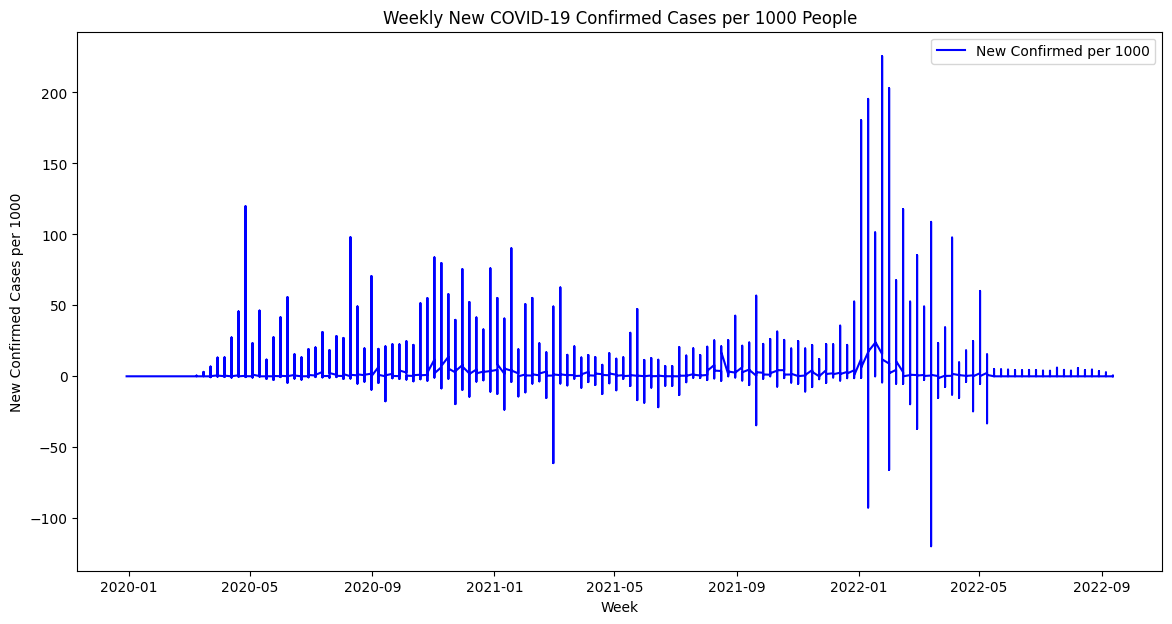

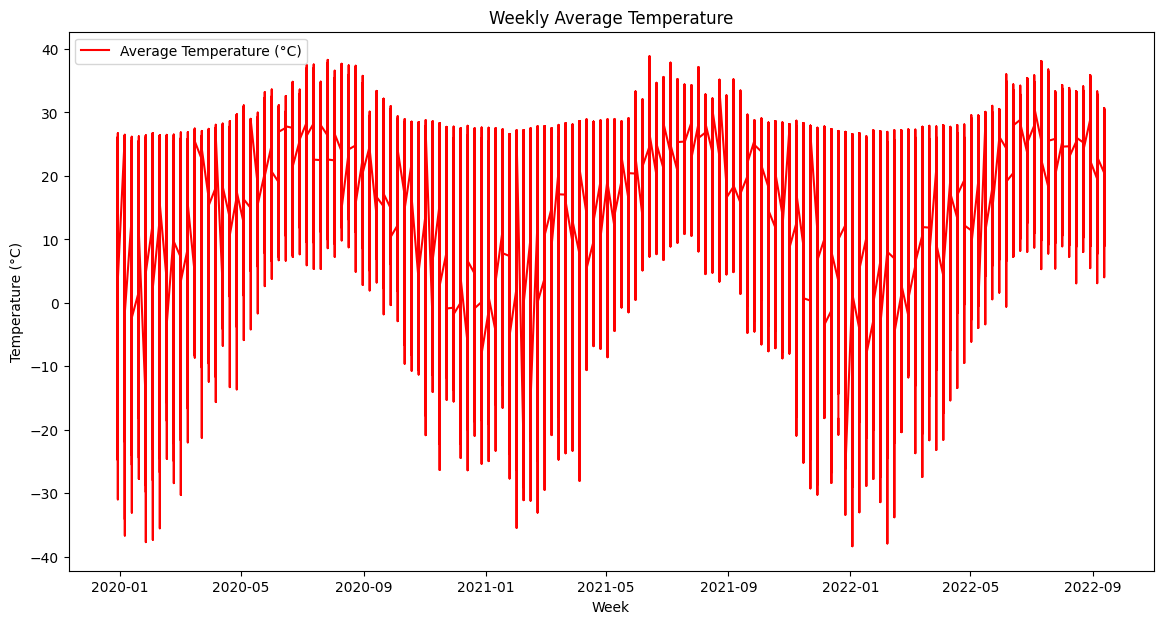

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your DataFrame is sorted by date if not already
weekly_df.sort_values('week', inplace=True)

# Plotting new confirmed cases over time
plt.figure(figsize=(14, 7))
plt.plot(weekly_df['week'], weekly_df['new_confirmed_per_1000'], label='New Confirmed per 1000', color='b')
plt.title('Weekly New COVID-19 Confirmed Cases per 1000 People')
plt.xlabel('Week')
plt.ylabel('New Confirmed Cases per 1000')
plt.legend()
plt.show()

# Plotting average temperature over time
plt.figure(figsize=(14, 7))
plt.plot(weekly_df['week'], weekly_df['average_temperature_celsius'], label='Average Temperature (°C)', color='r')
plt.title('Weekly Average Temperature')
plt.xlabel('Week')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Scatter Plot with Regression Line

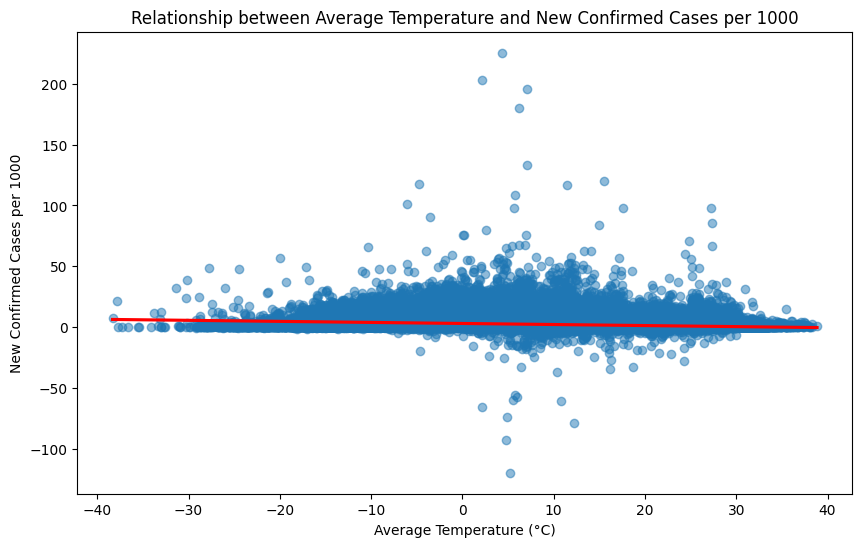

In [16]:
plt.figure(figsize=(10, 6))
sns.regplot(x='average_temperature_celsius', y='new_confirmed_per_1000', data=weekly_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between Average Temperature and New Confirmed Cases per 1000')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('New Confirmed Cases per 1000')
plt.show()


### Multiple Time Series on One Plot

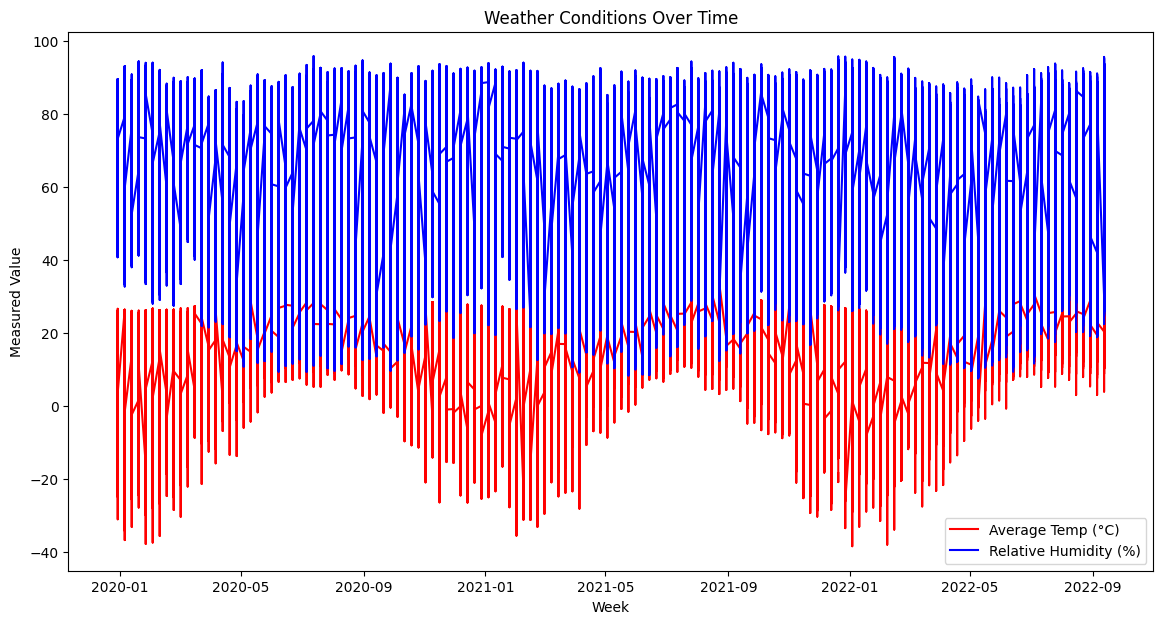

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(weekly_df['week'], weekly_df['average_temperature_celsius'], label='Average Temp (°C)', color='red')
plt.plot(weekly_df['week'], weekly_df['relative_humidity'], label='Relative Humidity (%)', color='blue')
plt.title('Weather Conditions Over Time')
plt.xlabel('Week')
plt.ylabel('Measured Value')
plt.legend()
plt.show()

### Heatmaps of Yearly/Monthly Data

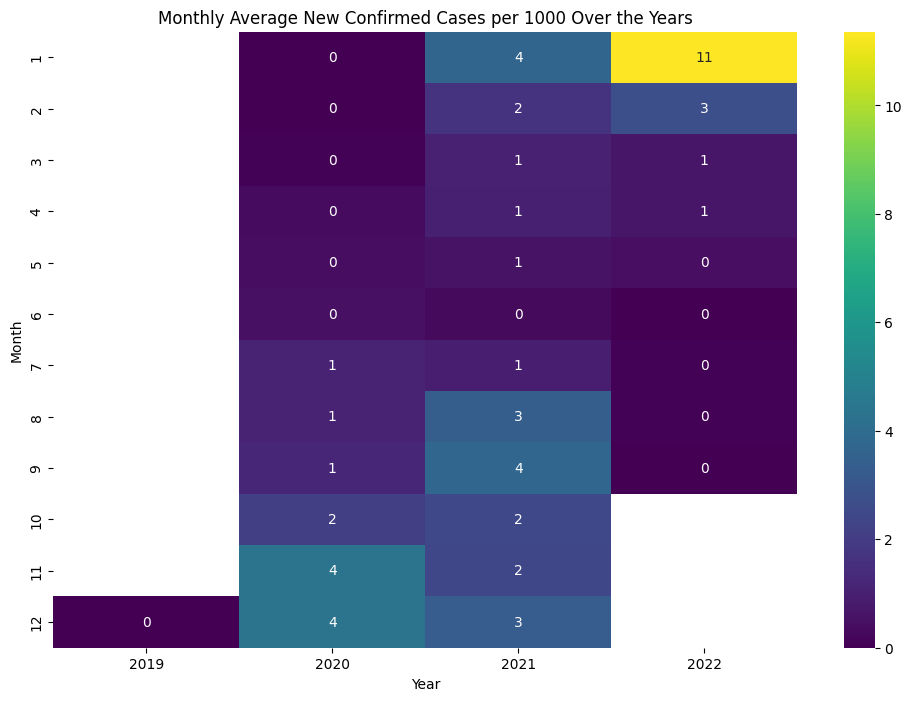

In [18]:
# Create a pivot table for heatmap
heatmap_data = weekly_df.pivot_table(values='new_confirmed_per_1000', index=weekly_df['week'].dt.month, columns=weekly_df['week'].dt.year, aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".0f")
plt.title('Monthly Average New Confirmed Cases per 1000 Over the Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

In [19]:
import statsmodels.api as sm

# Model without lagged variables
X_without_lags = weekly_df[['average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'rainfall_mm', 'relative_humidity']]
X_without_lags = sm.add_constant(X_without_lags)
model_without_lags = sm.OLS(weekly_df['new_confirmed_per_1000'], X_without_lags, missing='drop')
results_without_lags = model_without_lags.fit()
weekly_df['predicted_without_lags'] = results_without_lags.predict(X_without_lags)

# Model with lagged variables
X_with_lags = weekly_df[['average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'rainfall_mm', 'relative_humidity', 'lagged_new_confirmed_per_1000', 'lagged_avg_temp']]
X_with_lags = sm.add_constant(X_with_lags)
model_with_lags = sm.OLS(weekly_df['new_confirmed_per_1000'], X_with_lags, missing='drop')
results_with_lags = model_with_lags.fit()
weekly_df['predicted_with_lags'] = results_with_lags.predict(X_with_lags)


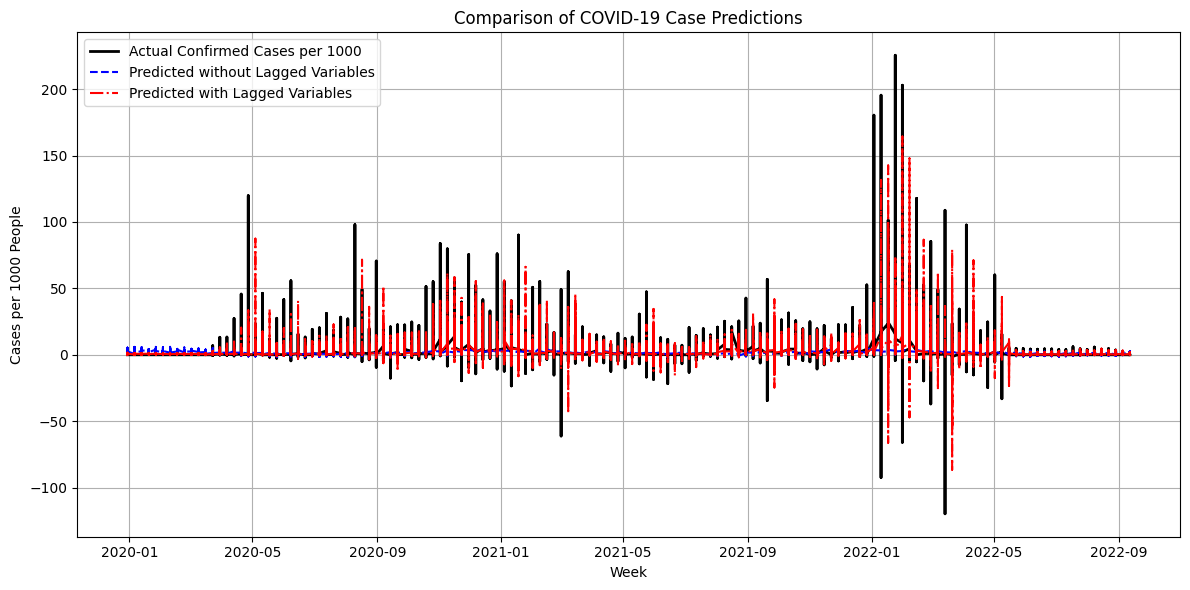

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(weekly_df['week'], weekly_df['new_confirmed_per_1000'], label='Actual Confirmed Cases per 1000', color='black', linewidth=2)
plt.plot(weekly_df['week'], weekly_df['predicted_without_lags'], label='Predicted without Lagged Variables', color='blue', linestyle='--')
plt.plot(weekly_df['week'], weekly_df['predicted_with_lags'], label='Predicted with Lagged Variables', color='red', linestyle='-.')
plt.title('Comparison of COVID-19 Case Predictions')
plt.xlabel('Week')
plt.ylabel('Cases per 1000 People')
plt.legend()
plt.grid(True)
plt.tight_layout()


